In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
from zipfile import ZipFile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -o /content/drive/MyDrive/PCOS.zip -d /content/


Archive:  /content/drive/MyDrive/PCOS.zip
  inflating: /content/PCOS/infected/img_0_1023.jpg  
  inflating: /content/PCOS/infected/img_0_1033.jpg  
  inflating: /content/PCOS/infected/img_0_1071.jpg  
  inflating: /content/PCOS/infected/img_0_1075.jpg  
  inflating: /content/PCOS/infected/img_0_1079.jpg  
  inflating: /content/PCOS/infected/img_0_1083.jpg  
  inflating: /content/PCOS/infected/img_0_1087.jpg  
  inflating: /content/PCOS/infected/img_0_1088.jpg  
  inflating: /content/PCOS/infected/img_0_1099.jpg  
  inflating: /content/PCOS/infected/img_0_113.jpg  
  inflating: /content/PCOS/infected/img_0_1130.jpg  
  inflating: /content/PCOS/infected/img_0_1141.jpg  
  inflating: /content/PCOS/infected/img_0_1142.jpg  
  inflating: /content/PCOS/infected/img_0_1182.jpg  
  inflating: /content/PCOS/infected/img_0_1195.jpg  
  inflating: /content/PCOS/infected/img_0_1223.jpg  
  inflating: /content/PCOS/infected/img_0_1226.jpg  
  inflating: /content/PCOS/infected/img_0_1234.jpg  
  inf

In [ ]:
import os

ROOT_DIR = '/content/PCOS'  # Updated path after unzipping
number_of_images = {}

for dir_name in os.listdir(ROOT_DIR):
    dir_path = os.path.join(ROOT_DIR, dir_name)
    if os.path.isdir(dir_path):
        number_of_images[dir_name] = len(os.listdir(dir_path))
        print(f"Directory: {dir_name}, Number of Images: {number_of_images[dir_name]}")




Directory: notinfected, Number of Images: 1143
Directory: infected, Number of Images: 781


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

In [ ]:
def preprocessingImage1(path):
  image_data = ImageDataGenerator(zoom_range=0.2,shear_range=0.2,preprocessing_function= preprocess_input,horizontal_flip=True)
  image = image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
  return image

In [ ]:
def preprocessionfImage2(path):
  """
  Input :path
  Output : preprocessed Image
  """
  image_data  = ImageDataGenerator(preprocessing_function= preprocess_input )
  image = image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')

  return image




We will split the data such that
70% for training
15 % for vailadation
15 % for testing



In [ ]:
def datafolder(path,split):
  if not os.path.exists("./"+path):
    os.mkdir("./"+path)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+path+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR,dir)),
                                  size=(math.floor(split * number_of_images[dir])-5),replace=False):

          O = os.path.join(ROOT_DIR,dir,img)
          D = os.path.join("./"+path,dir)
          shutil.copy(O,D)
          os.remove(O)

  else:
     print("Folder already exist")


In [ ]:
datafolder("train",0.7)

Folder already exist


In [ ]:
datafolder("val",0.15)

Folder already exist


In [ ]:
datafolder("test",0.15)

Folder already exist


In [ ]:
path ='/content/train'
train_data = preprocessingImage1(path)

Found 1336 images belonging to 2 classes.


In [ ]:
path ='/content/test'
test_data = preprocessionfImage2(path)

Found 278 images belonging to 2 classes.


In [ ]:
path = '/content/val'
val_data = preprocessionfImage2(path)

Found 278 images belonging to 2 classes.




Model Block




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten,Dense
from keras.models import Model,load_model
from keras.applications.mobilenet import MobileNet
import keras

In [ ]:
base_model = MobileNet(input_shape=(224,224,3),include_top=False)

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
x= Flatten()(base_model.output)
x= Dense(units=1,activation='sigmoid')(x)

In [ ]:
model = Model(base_model.input,x)

In [ ]:
model.compile(optimizer='rmsprop',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

mc = ModelCheckpoint(filepath="bestmodel.h5",monitor='val_accuracy',verbose=1,save_best_only=True)

#Early check points
es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=5,verbose=1)

cb = [mc,es]

In [ ]:
hist = model.fit_generator(train_data,
                           steps_per_epoch=10,
                           epochs=30,
                           validation_data=val_data,
                           validation_steps=16,
                          callbacks=cb)

<ipython-input-67-0bed7b29e770>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_data,


Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 1.0836 - accuracy: 0.8719


Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to bestmodel.h5
10/10 [==============================] - 43s 4s/step - loss: 1.0836 - accuracy: 0.8719 - val_loss: 5.0151e-04 - val_accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 1.3522e-05 - accuracy: 1.0000

10/10 [==============================] - 22s 2s/step - loss: 1.3522e-05 - accuracy: 1.0000
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 3.2126e-06 - accuracy: 1.0000

10/10 [==============================] - 21s 2s/step - loss: 3.2126e-06 - accuracy: 1.0000
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 2.6889e-05 - accuracy: 1.0000

10/10 [==============================] - 22s 2s/step - loss: 2.6889e-05 - accuracy: 1.0000
Epoch 5/30
10/10 [==============================] - ETA: 0s - loss: 2.9765e-06 - accuracy: 1.0000

10/10 [==============================] - 22s 2s/step - loss: 2.9765e-06 - accuracy: 1.0000
Epoch 6/30
10/10 [==============================] - ETA: 0s - loss: 4.5949e-06 - accuracy: 1.0000

10/10 [==============================] - 20s 2s/step - loss: 4.5949e-06 - accuracy: 1.0000
Epoch 7/30
10/10 [==============================] - ETA: 0s - loss: 1.2547 - accuracy: 0.9187

10/10 [==============================] - 22s 2s/step - loss: 1.2547 - accuracy: 0.9187
Epoch 8/30
10/10 [==============================] - ETA: 0s - loss: 8.1830e-08 - accuracy: 1.0000

10/10 [==============================] - 21s 2s/step - loss: 8.1830e-08 - accuracy: 1.0000
Epoch 9/30
10/10 [==============================] - ETA: 0s - loss: 1.5565e-07 - accuracy: 1.0000

10/10 [==============================] - 21s 2s/step - loss: 1.5565e-07 - accuracy: 1.0000
Epoch 10/30
10/10 [==============================] - ETA: 0s - loss: 2.5642e-07 - accuracy: 1.0000

10/10 [==============================] - 22s 2s/step - loss: 2.5642e-07 - accuracy: 1.0000
Epoch 11/30
10/10 [==============================] - ETA: 0s - loss: 6.3868e-09 - accuracy: 1.0000

10/10 [==============================] - 19s 2s/step - loss: 6.3868e-09 - accuracy: 1.0000
Epoch 12/30
10/10 [==============================] - ETA: 0s - loss: 2.3050e-07 - accuracy: 1.0000

10/10 [==============================] - 20s 2s/step - loss: 2.3050e-07 - accuracy: 1.0000
Epoch 13/30
10/10 [==============================] - ETA: 0s - loss: 4.4278e-08 - accuracy: 1.0000

10/10 [==============================] - 19s 2s/step - loss: 4.4278e-08 - accuracy: 1.0000
Epoch 14/30
10/10 [==============================] - ETA: 0s - loss: 1.4852e-06 - accuracy: 1.0000

10/10 [==============================] - 20s 2s/step - loss: 1.4852e-06 - accuracy: 1.0000
Epoch 15/30
10/10 [==============================] - ETA: 0s - loss: 1.0715e-06 - accuracy: 1.0000

10/10 [==============================] - 19s 2s/step - loss: 1.0715e-06 - accuracy: 1.0000
Epoch 16/30
10/10 [==============================] - ETA: 0s - loss: 4.4185e-08 - accuracy: 1.0000

10/10 [==============================] - 19s 2s/step - loss: 4.4185e-08 - accuracy: 1.0000
Epoch 17/30
10/10 [==============================] - ETA: 0s - loss: 8.3516e-09 - accuracy: 1.0000

10/10 [==============================] - 19s 2s/step - loss: 8.3516e-09 - accuracy: 1.0000
Epoch 18/30
10/10 [==============================] - ETA: 0s - loss: 2.7454e-08 - accuracy: 1.0000

10/10 [==============================] - 19s 2s/step - loss: 2.7454e-08 - accuracy: 1.0000
Epoch 19/30
10/10 [==============================] - ETA: 0s - loss: 1.0191e-08 - accuracy: 1.0000

10/10 [==============================] - 20s 2s/step - loss: 1.0191e-08 - accuracy: 1.0000
Epoch 20/30
10/10 [==============================] - ETA: 0s - loss: 1.1690e-08 - accuracy: 1.0000

10/10 [==============================] - 19s 2s/step - loss: 1.1690e-08 - accuracy: 1.0000
Epoch 21/30
10/10 [==============================] - ETA: 0s - loss: 2.6481e-08 - accuracy: 1.0000

10/10 [==============================] - 18s 2s/step - loss: 2.6481e-08 - accuracy: 1.0000
Epoch 22/30
10/10 [==============================] - ETA: 0s - loss: 1.1058e-07 - accuracy: 1.0000

10/10 [==============================] - 20s 2s/step - loss: 1.1058e-07 - accuracy: 1.0000
Epoch 23/30
10/10 [==============================] - ETA: 0s - loss: 1.0231e-08 - accuracy: 1.0000

10/10 [==============================] - 18s 2s/step - loss: 1.0231e-08 - accuracy: 1.0000
Epoch 24/30
10/10 [==============================] - ETA: 0s - loss: 1.6142e-08 - accuracy: 1.0000

10/10 [==============================] - 20s 2s/step - loss: 1.6142e-08 - accuracy: 1.0000
Epoch 25/30
10/10 [==============================] - ETA: 0s - loss: 3.3353e-08 - accuracy: 1.0000

10/10 [==============================] - 19s 2s/step - loss: 3.3353e-08 - accuracy: 1.0000
Epoch 26/30
10/10 [==============================] - ETA: 0s - loss: 1.3130e-09 - accuracy: 1.0000

10/10 [==============================] - 19s 2s/step - loss: 1.3130e-09 - accuracy: 1.0000
Epoch 27/30
10/10 [==============================] - ETA: 0s - loss: 5.5625e-08 - accuracy: 1.0000

10/10 [==============================] - 20s 2s/step - loss: 5.5625e-08 - accuracy: 1.0000
Epoch 28/30
10/10 [==============================] - ETA: 0s - loss: 8.3800e-10 - accuracy: 1.0000

10/10 [==============================] - 19s 2s/step - loss: 8.3800e-10 - accuracy: 1.0000
Epoch 29/30
10/10 [==============================] - ETA: 0s - loss: 7.1409e-10 - accuracy: 1.0000

10/10 [==============================] - 20s 2s/step - loss: 7.1409e-10 - accuracy: 1.0000
Epoch 30/30
10/10 [==============================] - ETA: 0s - loss: 2.4637e-06 - accuracy: 1.0000

10/10 [==============================] - 18s 2s/step - loss: 2.4637e-06 - accuracy: 1.0000


In [ ]:
model = load_model("/content/bestmodel.h5")

In [ ]:
acc = model.evaluate_generator(test_data)[1]
print(f"our model accuracy is  {acc * 100} %")

<ipython-input-69-fe794b425aa5>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(test_data)[1]


our model accuracy is  100.0 %


 Our model is perform well on the datasets.

The accuracy is 100.0 %

In [ ]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
train_data.class_indices

{'infected': 0, 'notinfected': 1}

In [ ]:
test_data.class_indices

{'infected': 0, 'notinfected': 1}

In [ ]:
val_data.class_indices

{'infected': 0, 'notinfected': 1}

In [ ]:
#now get some random images and predict the class
from keras.preprocessing import image
import tensorflow as tf


def predictimage(path):

      img = tf.keras.utils.load_img(path,target_size=(224,224))
      i = tf.keras.utils.img_to_array(img)/255
      input_arr= np.array([i])
      input_arr.shape

      pred =model.predict(input_arr)
      if pred == 1:
          print("Not Affected")
      else :
         print("Affected")
      #display image
      plt.imshow(input_arr[0],vmin=0, vmax=255)
      plt.title("input Image")
      plt.show()

1/1 [==============================] - 1s 588ms/step
Affected


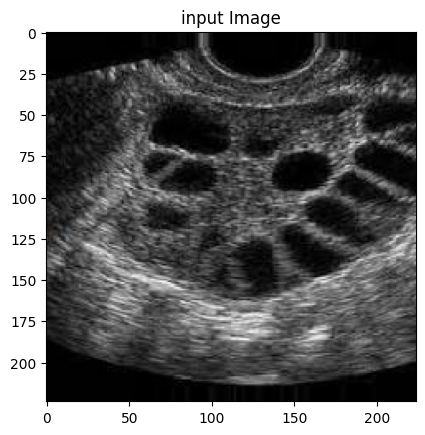

In [ ]:
#It is the infected image sample
predictimage("/content/PCOS/infected/img_0_113.jpg")

1/1 [==============================] - 0s 62ms/step
Not Affected


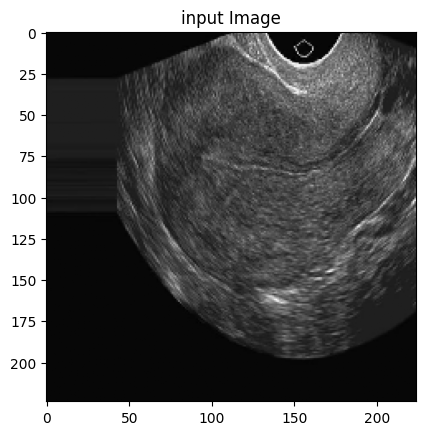

In [ ]:
#It is the not affected sample images
predictimage("/content/PCOS/notinfected/img_0_6858.jpg")

1/1 [==============================] - 0s 53ms/step
Not Affected


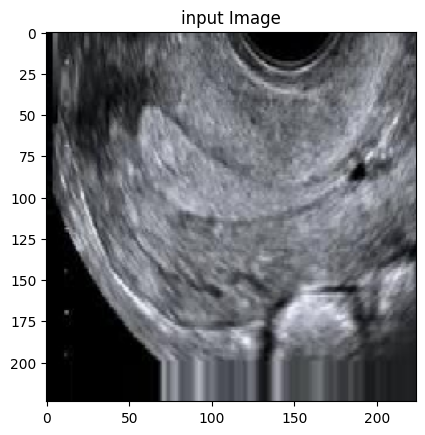

In [ ]:
#not infected image

predictimage("/content/PCOS/notinfected/img_0_1772.jpg")

1/1 [==============================] - 0s 58ms/step
Affected


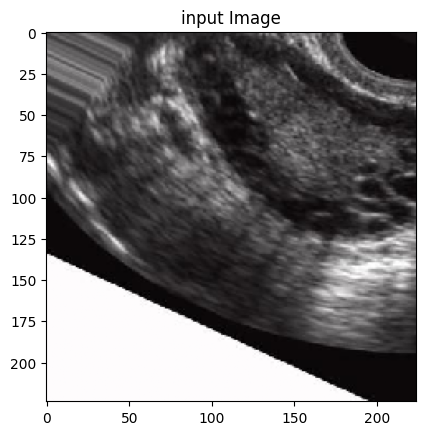

In [ ]:
predictimage("/content/PCOS/infected/img_0_9985.jpg")

In [ ]:
model.save('PCOS')

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('PCOS')
